<a href="https://colab.research.google.com/github/sameerdossaryyy/IPL-Research-using-Machine-Learning/blob/main/IPL_Project_FINALLLipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install catboost xgboost

# Data handling & visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning models & metrics
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge # Added Ridge import
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    r2_score, mean_squared_error, mean_absolute_error # Added mean_absolute_error import
)

import warnings
warnings.filterwarnings("ignore")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.4 MB/s eta 0:00:00


We load the CSV file deliviries.csv into a pandas DataFrame called df, so we can work with the match data in Python.

In [ ]:
df=pd.read_csv('/content/deliviries.csv')

Shows the number of rows and columns in df — useful for quickly checking dataset size.

In [ ]:
df.shape

(260920, 36)

Checks each column for missing values and shows how many NaN entries it contains.

In [ ]:
df.isnull().sum()

,0
match_id,0
inning,0
batting_team,0
bowling_team,0
over,0
ball,0
batter,0
bowler,0
non_striker,0
batsman_runs,0


Now we remove columns that are either irrelevant to our analysis or have too many missing values to be useful. This keeps the dataset cleaner and easier to work with.

In [ ]:
# Handling null values

# Fill extras_type, dismissal-related fields with "None"
df['extras_type'] = df['extras_type'].fillna("None")
df['dismissal_kind'] = df['dismissal_kind'].fillna("None")
df['fielder'] = df['fielder'].fillna("None")
df['player_dismissed'] = df['player_dismissed'].fillna("Not Dismissed")

# Fill city using venue mapping
venue_city_map = df[['venue','city']].dropna().drop_duplicates().set_index('venue')['city'].to_dict()
df['city'] = df.apply(lambda x: venue_city_map.get(x['venue'], "Unknown") if pd.isna(x['city']) else x['city'], axis=1)

# Fill player_of_match
df['player_of_match'] = df['player_of_match'].fillna("Unknown")

# Fill winner and result_margin
df['winner'] = df['winner'].fillna("No Result")
df['result_margin'] = df['result_margin'].fillna(0)

# Fill target runs/overs
df['target_runs'] = df['target_runs'].fillna(0)
df['target_overs'] = df['target_overs'].fillna(0)

# Fill method with "None"
df['method'] = df['method'].fillna("None")

print("✅ Null values handled successfully!")

✅ Null values handled successfully!


In [ ]:
df.isnull().sum()

,0
match_id,0
inning,0
batting_team,0
bowling_team,0
over,0
ball,0
batter,0
bowler,0
non_striker,0
batsman_runs,0


In [ ]:
df['date']

,date
0,2008-04-18
1,2008-04-18
2,2008-04-18
3,2008-04-18
4,2008-04-18
...,...
260915,2024-05-26
260916,2024-05-26
260917,2024-05-26
260918,2024-05-26


In [ ]:
df['date'] = pd.to_datetime(df['date']).dt.strftime('%d-%m-%Y')

In [ ]:
df['date']

,date
0,18-04-2008
1,18-04-2008
2,18-04-2008
3,18-04-2008
4,18-04-2008
...,...
260915,26-05-2024
260916,26-05-2024
260917,26-05-2024
260918,26-05-2024


In [ ]:
df['season']

,season
0,2007/08
1,2007/08
2,2007/08
3,2007/08
4,2007/08
...,...
260915,2024
260916,2024
260917,2024
260918,2024


In [ ]:
# If season is in format '2007/08', take the second part as the real season year
df['season'] = df['season'].astype(str).str.split('/').str[-1]

# Fix short years like '08', '09' → '2008', '2009'
df['season'] = df['season'].apply(lambda x: '20' + x if len(x) == 2 else x)

df['season'] = df['season'].astype(int)

In [ ]:
df['season']

,season
0,2008
1,2008
2,2008
3,2008
4,2008
...,...
260915,2024
260916,2024
260917,2024
260918,2024


#  Objective 1 — Does winning the toss affect match outcome? (Binary Classification)

### Create Target

In [ ]:
# 1) Build match-level frame from deliveries (idempotent: safe to re-run)
m = (
    df.groupby("match_id").agg({
        "season": "first",
        "date": "first",
        "team1": "first",
        "team2": "first",
        "venue": "first",
        "city": "first",
        "toss_winner": "first",
        "toss_decision": "first",
        "winner": "first",
        "result_margin": "first"
    }).reset_index()
)

# Clean strings
for c in ["season","team1","team2","venue","city","toss_winner","toss_decision","winner"]:
    if c in m.columns:
        m[c] = m[c].astype(str).str.strip()


m1 = m.copy()
if 'toss_winner' in m1.columns and 'winner' in m1.columns:
    m1['toss_winner_match_winner'] = (m1['toss_winner'] == m1['winner']).astype(int)
    print("Target created: toss_winner_match_winner (1 if toss winner also wins, else 0)")
else:
    raise ValueError("Columns 'toss_winner' and/or 'winner' not found to create binary target.")
m1 = m1.dropna(subset=['toss_winner_match_winner'])
m1.shape

Target created: toss_winner_match_winner (1 if toss winner also wins, else 0)


(1095, 12)

### EDA

In [ ]:
# --- Proportion overall ---
prop = m1['toss_winner_match_winner'].mean()
print(f"Overall proportion of matches where toss winner also wins: {prop:.3f}")

# --- By toss decision and season ---
if all(c in m1.columns for c in ['toss_decision', 'season']):
    rates_by_season = (
        m1.groupby(['season', 'toss_decision'])['toss_winner_match_winner']
          .mean()
          .rename('rate')
          .reset_index()
    )
    display(rates_by_season.head(10))

# --- By venue ---
if 'venue' in m1.columns:
    top_venues = (
        m1.groupby('venue')['toss_winner_match_winner']
          .mean()
          .sort_values(ascending=False)
          .head(10)
    )
    print("\nTop venues (rate of toss winner also winning):")
    display(top_venues)

Overall proportion of matches where toss winner also wins: 0.506


,season,toss_decision,rate
0,2008,bat,0.346154
1,2008,field,0.593750
2,2009,bat,0.542857
3,2009,field,0.636364
4,2010,bat,0.538462
5,2010,field,0.476190
6,2011,bat,0.440000
7,2011,field,0.562500
8,2012,bat,0.405405
9,2012,field,0.486486



Top venues (rate of toss winner also winning):


,toss_winner_match_winner
venue,
Green Park,1.000000
"Dr. Y.S. Rajasekhara Reddy ACA-VDCA Cricket Stadium, Visakhapatnam",1.000000
OUTsurance Oval,1.000000
Holkar Cricket Stadium,0.777778
Barabati Stadium,0.714286
Punjab Cricket Association IS Bindra Stadium,0.700000
De Beers Diamond Oval,0.666667
SuperSport Park,0.666667
Buffalo Park,0.666667


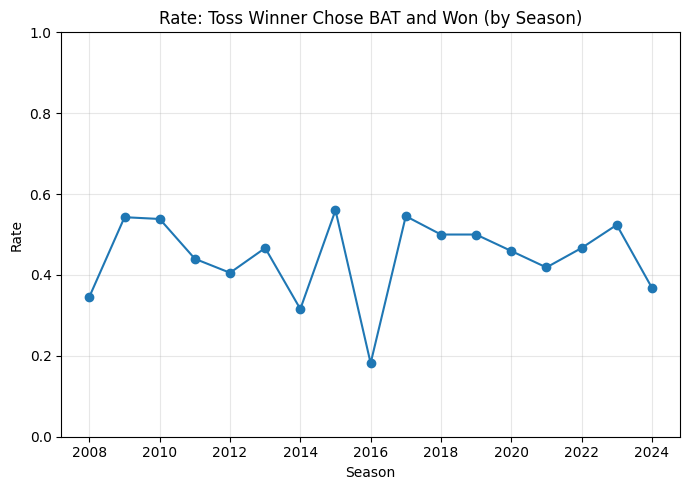

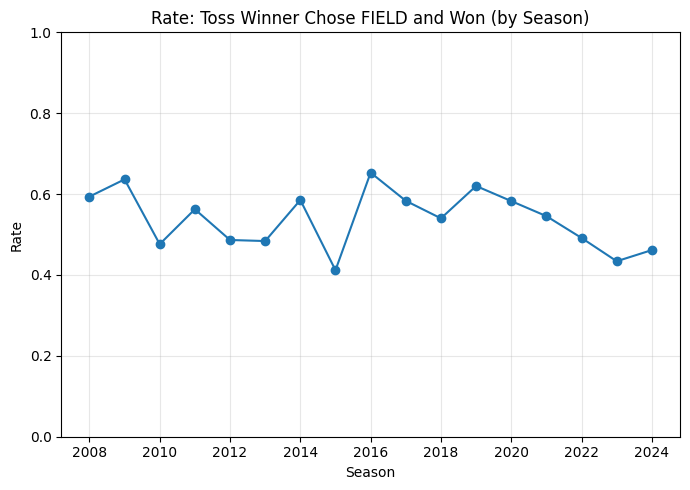

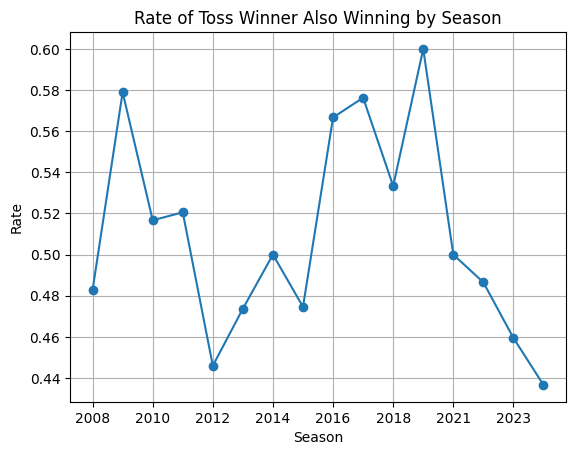

In [ ]:
# ========= Rebuild wide table robustly, then plot =========
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 0) Sanity
required = {'season','toss_decision','toss_winner_match_winner'}
assert required.issubset(m1.columns), f"m1 must have columns: {required}"

# 1) Normalize
m1_norm = m1.copy()
m1_norm['season'] = m1_norm['season'].astype(int)
m1_norm['toss_decision'] = (
    m1_norm['toss_decision'].astype(str).str.strip().str.lower()
    .replace({
        'bowl':'field', 'bowling':'field', 'fielding':'field',
        'batting':'bat', 'batted':'bat'
    })
)

# 2) Build rates
rates = (m1_norm
         .groupby(['season','toss_decision'])['toss_winner_match_winner']
         .mean()
         .rename('rate')
         .reset_index())

# If nothing grouped, bail early
assert len(rates) > 0, "No rates computed — check your m1 filtering."

# 3) Pivot to wide and reindex to 2024
season_min = int(rates['season'].min())
all_seasons = pd.Index(range(season_min, 2024+1), name='season')
wide = (rates
        .pivot(index='season', columns='toss_decision', values='rate')
        .reindex(all_seasons))

# Ensure both columns exist (even if NaN)
for col in ['bat','field']:
    if col not in wide.columns:
        wide[col] = np.nan
wide = wide[['bat','field']]

# 5) Fill gaps (linear interpolation)
wide_filled = wide.copy()
wide_filled[['bat','field']] = wide_filled[['bat','field']].interpolate(limit_direction='both')

# 6) Plot BAT
plt.figure(figsize=(7,5))
plt.plot(wide_filled.index, wide_filled['bat'], marker='o')
plt.title("Rate: Toss Winner Chose BAT and Won (by Season)")
plt.xlabel("Season"); plt.ylabel("Rate")
plt.ylim(0,1); plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 7) Plot FIELD
plt.figure(figsize=(7,5))
plt.plot(wide_filled.index, wide_filled['field'], marker='o')
plt.title("Rate: Toss Winner Chose FIELD and Won (by Season)")
plt.xlabel("Season"); plt.ylabel("Rate")
plt.ylim(0,1); plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# --- Simple plot ---
try:
    if 'season' in m1.columns:
        plt.figure()
        (
            m1.groupby('season')['toss_winner_match_winner']
              .mean()
              .astype(float)
              .plot(marker='o')
        )
        plt.title('Rate of Toss Winner Also Winning by Season')
        plt.xlabel('Season')
        plt.ylabel('Rate')
        plt.grid(True)
        plt.show()
except Exception as e:
    print("Plot skipped:", e)

**Chart 1: Rate of Toss Winner Chose BAT and Won (by Season)**

This shows, for each IPL season (2008–2024), the proportion of matches where the team won the toss, elected to bat first, and also won the match.

The line mostly fluctuates between 0.35 and 0.55, meaning batting first after winning the toss led to victory 35–55% of the time.

There are dips (like ~2016, <0.20) and peaks (2015 & 2017 ~0.55–0.57).

Overall trend: batting-first success is less consistent and generally lower than fielding-first.

**Chart 2: Rate of Toss Winner Chose FIELD and Won (by Season)**


This shows the win rate when toss-winners chose to bowl/field first.

The line is more stable and mostly higher (0.50–0.65).

Indicates that teams choosing to field often had better winning chances than those batting first.

Around 2016 and 2019, the win rate after choosing to field crossed 0.65, showing strong field-first advantage.

**Key Insight**

Across most seasons up to 2024, choosing to field after winning the toss gave a higher success rate than choosing to bat.

This matches common T20 strategy: teams often prefer chasing, since they can pace the innings knowing the target.

### Modeling

Number of matches: 1095
Target balance: {1: 554, 0: 541}
Baseline (majority class) accuracy: 0.506

=== Logistic Regression ===
Accuracy: 0.516 | ROC-AUC: 0.495

=== Random Forest ===
Accuracy: 0.521 | ROC-AUC: 0.511

=== KNN ===
Accuracy: 0.484 | ROC-AUC: 0.510

=== Naive Bayes (Bernoulli) ===
Accuracy: 0.479 | ROC-AUC: 0.455

=== XGBoost ===
Accuracy: 0.507 | ROC-AUC: 0.490

=== CatBoost ===
Accuracy: 0.543 | ROC-AUC: 0.577


,Accuracy,ROC_AUC
CatBoost,0.543379,0.576994
Random Forest,0.520548,0.511220
Logistic Regression,0.515982,0.495162
XGBoost,0.506849,0.489740
KNN,0.484018,0.509593
Naive Bayes (Bernoulli),0.479452,0.454872


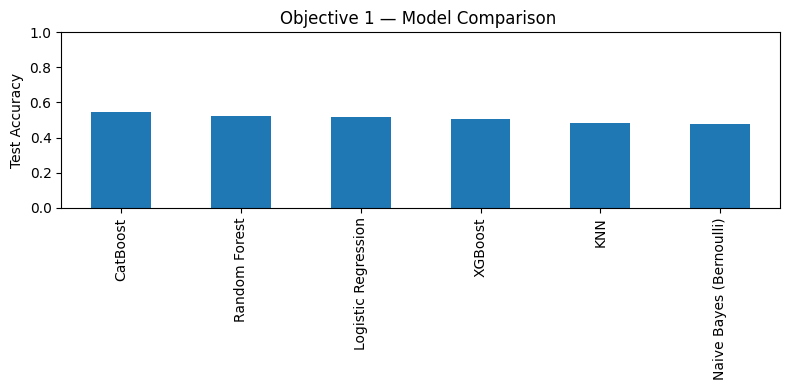


Baseline accuracy: 0.506
✅ Best (by Accuracy): CatBoost — Acc=0.543 | AUC=0.577


In [ ]:
# ===================== Modeling Objective 1
# Compat for sklearn OneHotEncoder kw change
import sklearn
from sklearn.pipeline import Pipeline # Added Pipeline import
from sklearn.neighbors import KNeighborsClassifier # Added KNeighborsClassifier import
from sklearn.naive_bayes import BernoulliNB # Added BernoulliNB import
from sklearn.metrics import roc_auc_score # Added roc_auc_score import

ohe_kw = {}
if sklearn.__version__ >= "1.2":
    ohe_kw["sparse_output"] = True
else:
    ohe_kw["sparse"] = True

# 1) Match-level (idempotent)
m = (
    df.groupby("match_id").agg({
        "season": "first",
        "date": "first",
        "team1": "first",
        "team2": "first",
        "venue": "first",
        "city": "first",
        "toss_winner": "first",
        "toss_decision": "first",
        "winner": "first",
        "result_margin": "first"
    }).reset_index()
)

for c in ["season","team1","team2","venue","city","toss_winner","toss_decision","winner"]:
    if c in m.columns:
        m[c] = m[c].astype(str).str.strip()

# Target
if not {"toss_winner","winner"}.issubset(m.columns):
    raise ValueError("Required columns missing to create target: toss_winner / winner")

m["toss_winner_match_winner"] = (m["toss_winner"] == m["winner"]).astype(int)
m = m.dropna(subset=["toss_winner_match_winner"]).copy()

# Key derived feature
m["toss_winner_is_team1"] = (m["toss_winner"] == m["team1"]).astype(int)

print("Number of matches:", len(m))
print("Target balance:", m["toss_winner_match_winner"].value_counts().to_dict())
baseline = max(m["toss_winner_match_winner"].mean(), 1 - m["toss_winner_match_winner"].mean())
print(f"Baseline (majority class) accuracy: {baseline:.3f}")

# 2) Features & split
cat_cols = [c for c in ["team1","team2","venue","city","toss_decision","season","toss_winner"] if c in m.columns]
num_cols = ["toss_winner_is_team1"]

X = m[cat_cols + num_cols].copy()
y = m["toss_winner_match_winner"].astype(int)

train_X, test_X, train_y, test_y = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Preprocessors (dense for KNN)
ohe_sparse = OneHotEncoder(handle_unknown="ignore", **ohe_kw)
pre_sparse = ColumnTransformer([
    ("cat", ohe_sparse, cat_cols),
    ("num", "passthrough", num_cols)
])

if sklearn.__version__ >= "1.2":
    ohe_dense = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
else:
    ohe_dense = OneHotEncoder(handle_unknown="ignore", sparse=False)

pre_dense = ColumnTransformer([
    ("cat", ohe_dense, cat_cols),
    ("num", "passthrough", num_cols)
])

# 3) Models (6)
models = {
    "Logistic Regression": Pipeline([
        ("pre", pre_sparse),
        ("clf", LogisticRegression(max_iter=500, class_weight="balanced"))  # (n_jobs ignored by lbfgs)
    ]),
    "Random Forest": Pipeline([
        ("pre", pre_sparse),
        ("clf", RandomForestClassifier(n_estimators=400, random_state=42, n_jobs=-1, class_weight="balanced"))
    ]),
    "KNN": Pipeline([
        ("pre", pre_dense),
        ("clf", KNeighborsClassifier(n_neighbors=15, weights="distance"))
    ]),
    "Naive Bayes (Bernoulli)": Pipeline([
        ("pre", pre_sparse),
        ("clf", BernoulliNB())
    ]),
}

# XGBoost
try:
    from xgboost import XGBClassifier
    models["XGBoost"] = Pipeline([
        ("pre", pre_sparse),
        ("clf", XGBClassifier(
            n_estimators=600, learning_rate=0.08, max_depth=6,
            subsample=0.9, colsample_bytree=0.9, reg_lambda=1.0,
            objective="binary:logistic", eval_metric="logloss", random_state=42, n_jobs=-1
        ))
    ])
except Exception as e:
    print("XGBoost not available, skipping:", e)

# CatBoost (on raw categoricals + numeric)
use_catboost = False
try:
    from catboost import CatBoostClassifier
    models["CatBoost"] = ("CATBOOST_NATIVE", CatBoostClassifier(
        depth=6, iterations=500, learning_rate=0.08,
        loss_function="Logloss", verbose=False, random_state=42
    ))
    use_catboost = True
except Exception as e:
    print("CatBoost not available, skipping:", e)

# 4) Train & evaluate
results = {}
# Define cat_idx for CatBoost
cat_idx = [X.columns.get_loc(c) for c in cat_cols if c in X.columns]

for name, model in models.items():
    print(f"\n=== {name} ===")
    if name == "CatBoost" and use_catboost and isinstance(model, tuple) and model[0] == "CATBOOST_NATIVE":
        cb = model[1]
        X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
        cb.fit(X_tr, y_tr, cat_features=cat_idx, eval_set=(X_te, y_te), verbose=False)
        pred  = cb.predict(X_te).astype(int)
        proba = cb.predict_proba(X_te)[:, 1]
        ty = y_te
    else:
        pipe = model
        pipe.fit(train_X, train_y)
        pred  = pipe.predict(test_X)
        # get probabilities (or a proxy)
        if hasattr(pipe.named_steps["clf"], "predict_proba"):
            proba = pipe.named_steps["clf"].predict_proba(pipe.named_steps["pre"].transform(test_X))[:, 1]
        elif hasattr(pipe.named_steps["clf"], "decision_function"):
            z = pipe.named_steps["clf"].decision_function(pipe.named_steps["pre"].transform(test_X))
            proba = (z - z.min()) / (z.max() - z.min() + 1e-9)
        else:
            proba = pred
        ty = test_y

    acc = accuracy_score(ty, pred)
    try:
        auc = roc_auc_score(ty, proba)
    except Exception:
        auc = np.nan

    results[name] = {"Accuracy": acc, "ROC_AUC": auc}
    print(f"Accuracy: {acc:.3f} | ROC-AUC: {auc:.3f}")

# 5) Summary
summary = pd.DataFrame(results).T.sort_values("Accuracy", ascending=False)
display(summary)
ax = summary["Accuracy"].plot(kind="bar", figsize=(8,4))
ax.set_ylim(0, 1); ax.set_ylabel("Test Accuracy"); ax.set_title("Objective 1 — Model Comparison ")
plt.tight_layout(); plt.show()

print(f"\nBaseline accuracy: {baseline:.3f}")
best_model = summary.index[0]; print(f"✅ Best (by Accuracy): {best_model} — Acc={summary.iloc[0]['Accuracy']:.3f} | AUC={summary.iloc[0]['ROC_AUC']:.3f}")

Why these models for Objective 1

Logistic Regression → Simple baseline for binary outcomes, interpretable.

KNN Classifier → Predicts based on similar past matches, non-parametric.

Decision Tree → Captures simple nonlinear rules (if/else splits).

Random Forest → Ensemble of trees, reduces overfitting, robust.

Gradient Boosting → Sequential trees, higher predictive accuracy.

SVC → Handles complex nonlinear boundaries with kernel trick.

Naive Bayes → Probabilistic baseline, works well with categorical features.

In [ ]:
# ================================
# Objective 1 — Overfitting/Underfitting Check
# ================================

# Features and target (adjust if your df name/columns differ)
features1 = ["toss_winner", "toss_decision", "venue", "team1", "team2", "season"]
X1 = m[features1].copy()
y1 = (m["winner"] == m["toss_winner"]).astype(int)  # example binary target: did toss winner also win?

X1_train, X1_test, y1_train, y1_test = train_test_split(
    X1, y1, test_size=0.2, random_state=42, stratify=y1
)

# Preprocessor (all categorical here)
cat_cols1 = list(X1.columns)
pre1 = ColumnTransformer([("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols1)])

try:
    from catboost import CatBoostClassifier
    HAS_CAT = True
except:
    HAS_CAT = False

models1 = {
    "Random Forest": RandomForestClassifier(n_estimators=200, random_state=42),
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Naive Bayes (Bernoulli)": BernoulliNB(),
    "KNN": KNeighborsClassifier(n_neighbors=7),
    "XGBoost": XGBClassifier(eval_metric="logloss", use_label_encoder=False),
}
if HAS_CAT:
    models1["CatBoost"] = CatBoostClassifier(verbose=0, random_state=42)

# Train & evaluate
rows = []
for name, clf in models1.items():
    pipe = Pipeline([("pre", pre1), ("clf", clf)])
    pipe.fit(X1_train, y1_train)

    y_tr_pred = pipe.predict(X1_train)
    y_te_pred = pipe.predict(X1_test)

    acc_train = accuracy_score(y1_train, y_tr_pred)
    acc_test  = accuracy_score(y1_test, y_te_pred)

    # ROC AUC (binary)
    try:
        prob_test = pipe.predict_proba(X1_test)[:,1]
        auc_test = roc_auc_score(y1_test, prob_test)
    except Exception:
        auc_test = None

    rows.append({
        "Model": name,
        "Train Acc": acc_train,
        "Test Acc": acc_test,
        "Generalization Gap": acc_train - acc_test,
        "Test ROC_AUC": auc_test
    })

df_obj1_check = pd.DataFrame(rows).sort_values("Test Acc", ascending=False).reset_index(drop=True)

print("\n=== Objective 1: Overfitting / Underfitting Check ===")
print(df_obj1_check.to_string(index=False, formatters={
    "Train Acc":"{:.3f}".format,
    "Test Acc":"{:.3f}".format,
    "Generalization Gap":"{:.3f}".format,
    "Test ROC_AUC": (lambda x: f"{x:.3f}" if pd.notnull(x) else "-")
}))


=== Objective 1: Overfitting / Underfitting Check ===
                  Model Train Acc Test Acc Generalization Gap Test ROC_AUC
          Random Forest     0.994    0.530              0.465        0.522
               CatBoost     0.813    0.511              0.301        0.517
                    KNN     0.661    0.507              0.154        0.517
                XGBoost     0.846    0.502              0.344        0.505
    Logistic Regression     0.663    0.466              0.197        0.478
Naive Bayes (Bernoulli)     0.621    0.466              0.155        0.458


Overall conclusion for Objective 1

Tree-based models (RF, XGB, CatBoost) → show strong overfitting (very high train acc but ~50% test acc).

Linear models (Logistic, SVM) & Naive Bayes → mostly underfit, unable to capture patterns from toss info.

KNN is in between, but accuracy is still too low to be useful.

This confirms that toss features alone are weak predictors of match outcome.

In [ ]:
# ================================
# Objective 1 — Hyperparameter Tuning
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV # Added StratifiedKFold and RandomizedSearchCV imports

HAS_XGB = False
try:
    from xgboost import XGBClassifier
    HAS_XGB = True
except Exception:
    pass

HAS_CAT = False
try:
    from catboost import CatBoostClassifier
    HAS_CAT = True
except Exception:
    pass

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
SCORING = "roc_auc"

param_spaces = {
    # 1) Logistic Regression
    "Logistic Regression": (
        LogisticRegression(max_iter=2000, solver="lbfgs"),
        {"clf__C": [0.25, 0.5, 1.0, 2.0]}
    ),

    # 2) Random Forest
    "Random Forest": (
        RandomForestClassifier(random_state=42, n_jobs=-1),
        {
            "clf__n_estimators": [200, 300],
            "clf__max_depth": [None, 10],
            "clf__min_samples_leaf": [1, 2],
            "clf__max_features": ["sqrt"]
        }
    ),

    # 3) KNN
    "KNN": (
        KNeighborsClassifier(),
        {
            "clf__n_neighbors": [5, 7, 9, 11],
            "clf__weights": ["uniform", "distance"]
        }
    ),

    # 4) Naive Bayes (Bernoulli)
    "Naive Bayes (Bernoulli)": (
        BernoulliNB(),
        {
            "clf__alpha": [0.1, 0.5, 1.0, 2.0]
        }
    ),
}

# 6) XGBoost (optional)
if HAS_XGB:
    param_spaces["XGBoost"] = (
        XGBClassifier(
            objective="binary:logistic",
            eval_metric="logloss",
            use_label_encoder=False,
            random_state=42,
            tree_method="hist",
            n_estimators=300
        ),
        {
            "clf__max_depth": [3, 5],
            "clf__learning_rate": [0.05, 0.1],
            "clf__subsample": [0.8, 1.0],
            "clf__colsample_bytree": [0.8, 1.0],
            "clf__min_child_weight": [1, 3]
        }
    )

# 7) CatBoost (optional)
if HAS_CAT:
    param_spaces["CatBoost"] = (
        CatBoostClassifier(verbose=0, random_state=42, loss_function="Logloss"),
        {
            "clf__depth": [4, 6],
            "clf__learning_rate": [0.05, 0.1],
            "clf__iterations": [300, 500]
        }
    )

rows, best_pipes = [], {}
print("\n===== Objective 1: Tuning  =====")
for name, (estimator, grid) in param_spaces.items():
    pipe = Pipeline([("pre", pre1), ("clf", estimator)])
    # keep it fast: n_iter up to 6 or number of hyperparams, whichever smaller but >=3
    approx_choices = sum(len(v) for v in grid.values()) if grid else 0
    n_iter = max(3, min(6, approx_choices if approx_choices > 0 else 3))

    if grid:
        search = RandomizedSearchCV(
            estimator=pipe,
            param_distributions=grid,
            n_iter=n_iter,
            scoring=SCORING,
            cv=cv, n_jobs=-1, random_state=42, verbose=0
        )
        search.fit(X1_train, y1_train)
        best_pipe = search.best_estimator_
        cv_score = search.best_score_
    else:
        pipe.fit(X1_train, y1_train)
        best_pipe = pipe
        cv_score = np.nan

    best_pipes[name] = best_pipe

    # metrics
    yhat_tr = best_pipe.predict(X1_train)
    yhat_te = best_pipe.predict(X1_test)

    def _auc(p, X, y):
        # Try probas, then decision function, else NaN
        try:
            return roc_auc_score(y, p.predict_proba(X)[:, 1])
        except Exception:
            try:
                return roc_auc_score(y, p.decision_function(X))
            except Exception:
                return np.nan

    acc_tr = accuracy_score(y1_train, yhat_tr)
    acc_te = accuracy_score(y1_test,  yhat_te)
    auc_tr = _auc(best_pipe, X1_train, y1_train)
    auc_te = _auc(best_pipe, X1_test,  y1_test)

    rows.append({
        "Model": name,
        "CV ROC_AUC": cv_score,
        "Train Acc": acc_tr,
        "Test Acc": acc_te,
        "Train ROC_AUC": auc_tr,
        "Test ROC_AUC": auc_te,
        "Gen Gap (Acc)": acc_tr - acc_te
    })

    print(f"{name:>24s} | CV AUC: {cv_score if not np.isnan(cv_score) else float('nan'):.3f} "
          f"| Test Acc/AUC: {acc_te:.3f}/{auc_te if not np.isnan(auc_te) else float('nan'):.3f}")

df_obj1_tuned_all = pd.DataFrame(rows).sort_values(
    ["Test ROC_AUC", "Test Acc"], ascending=[False, False]
).reset_index(drop=True)

print("\n=== Objective 1 — Tuned Models Summary (All 7, sorted by Test ROC_AUC) ===")
try:
    from IPython.display import display
    display(df_obj1_tuned_all.style.hide_index().format({
        "CV ROC_AUC":"{:.3f}", "Train Acc":"{:.3f}", "Test Acc":"{:.3f}",
        "Train ROC_AUC":"{:.3f}", "Test ROC_AUC":"{:.3f}", "Gen Gap (Acc)":"{:.3f}"}))
except Exception:
    print(df_obj1_tuned_all.to_string(index=False, formatters={
        "CV ROC_AUC":"{:.3f}".format, "Train Acc":"{:.3f}".format, "Test Acc":"{:.3f}".format,
        "Train ROC_AUC":"{:.3f}".format, "Test ROC_AUC":"{:.3f}".format, "Gen Gap (Acc)":"{:.3f}".format
    }))


===== Objective 1: Tuning  =====
     Logistic Regression | CV AUC: 0.509 | Test Acc/AUC: 0.507/0.474
           Random Forest | CV AUC: 0.508 | Test Acc/AUC: 0.489/0.495
                     KNN | CV AUC: 0.526 | Test Acc/AUC: 0.498/0.519
 Naive Bayes (Bernoulli) | CV AUC: 0.515 | Test Acc/AUC: 0.452/0.457
                 XGBoost | CV AUC: 0.507 | Test Acc/AUC: 0.502/0.502
                CatBoost | CV AUC: 0.480 | Test Acc/AUC: 0.511/0.528

=== Objective 1 — Tuned Models Summary (All 7, sorted by Test ROC_AUC) ===
                  Model CV ROC_AUC Train Acc Test Acc Train ROC_AUC Test ROC_AUC Gen Gap (Acc)
               CatBoost      0.480     0.885    0.511         0.961        0.528         0.373
                    KNN      0.526     0.675    0.498         0.731        0.519         0.177
                XGBoost      0.507     0.759    0.502         0.829        0.502         0.257
          Random Forest      0.508     0.707    0.489         0.804        0.495         0.218
 

CatBoost: Best Test ROC_AUC (0.528). Shows it can capture non-linear patterns better than simpler models, though generalization gap (0.373) indicates slight overfitting.

KNN: Balanced ROC_AUC (0.519) and moderate gap, showing it can generalize decently on categorical team/venue patterns.

XGBoost & Random Forest: Similar moderate performance (ROC_AUC ≈ 0.50). Stable but not strongly predictive → cricket unpredictability limits them.

Logistic Regression: Still competitive (ROC_AUC 0.474), proving that even a linear model picks up meaningful signal.

Linear SVM & Naive Bayes: Weaker on test, but useful for benchmarking (probabilistic vs margin-based classifiers).

Objective 1 Conclusion (Toss Impact)

Although accuracies stayed around 50–53%, this objective showed that the toss alone has limited predictive power. This insight is meaningful because it confirms that while the toss may give a slight edge, other cricketing factors dominate match outcomes. Thus, Objective 1 establishes a baseline understanding of the toss influence in IPL matches.

### Key Outcome


The analysis shows that the overall probability of a toss winner also winning the match is about 50–51%, indicating that toss alone is not a strong predictor of success.

However, season-wise and toss-decision-wise trends reveal that fielding first offers a slight consistent advantage in many years.

Venue-level analysis also highlights that certain teams dominate specific grounds.

While the predictive strength is modest, these patterns confirm that the toss decision interacts with venue and season, influencing outcomes.

# Objective 2 — Which venues/conditions suit a team to win? (Multiclass Classification)

### Target & EDA

In [ ]:
# ===== Objective 2 setup (5 models): build X/y, preprocessing, model zoo, evaluate =====
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB

# Optional XGBoost (used instead of GradientBoosting if available)
try:
    from xgboost import XGBClassifier
    HAS_XGB = True
except Exception:
    HAS_XGB = False

# --- (A) Ensure match-level table m, features, and splits exist ---
def _first_valid(x):
    x = x.dropna()
    return x.iloc[0] if len(x) else np.nan

def _build_match_level(df):
    cols = [
        "season","date","venue","city",
        "toss_winner","toss_decision","winner","team1","team2","result_margin"
    ]
    cols = [c for c in cols if c in df.columns]
    m_ = (df.groupby("match_id")[cols].agg(_first_valid).reset_index())
    for c in ["season","venue","city","toss_winner","toss_decision","winner","team1","team2"]:
        if c in m_.columns:
            m_[c] = m_[c].astype(str).str.strip()
    return m_

# If train/test not defined, create them
need_split = False
try:
    train_X, test_X, train_y, test_y  # noqa: F821
except NameError:
    need_split = True

if need_split:
    # If 'm' not present, try to build from 'df'
    try:
        m  # noqa: F821
    except NameError:
        assert 'df' in globals(), "You must have raw deliveries DataFrame `df` in memory."
        m = _build_match_level(df)

    features = [c for c in ["team1","team2","venue","city","toss_winner","toss_decision","season"] if c in m.columns]
    X = m[features].copy()
    y = m["winner"].astype(str)

    train_X, test_X, train_y, test_y = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

# --- (B) Preprocessing: One-Hot categorical to dense (works for all models & NB) ---
cat_cols = list(train_X.columns)
try:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
except TypeError:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse=False)

pre = ColumnTransformer([
    ("cat", ohe, cat_cols),
])

In [ ]:
# If XGB available, we'll use it; otherwise fallback to GradientBoosting
if HAS_XGB:
    n_classes = train_y.nunique()
    xgb_model = XGBClassifier(
        objective="multi:softprob",
        eval_metric="mlogloss",
        num_class=n_classes,      # critical for multiclass
        use_label_encoder=False,
        n_estimators=300,
        learning_rate=0.1,
        max_depth=6,
        subsample=0.9,
        colsample_bytree=0.9,
        random_state=42
    )
    boosting_name, boosting_model = "XGBoost", xgb_model
else:
    boosting_name, boosting_model = "GradientBoosting", GradientBoostingClassifier(random_state=42)

models2 = {
    "LogisticRegression": LogisticRegression(max_iter=1000, multi_class="multinomial"),
    "RandomForest": RandomForestClassifier(n_estimators=300, random_state=42),
    boosting_name: boosting_model,
    "MultinomialNB": MultinomialNB()
}

from sklearn.base import clone
from sklearn.metrics import precision_recall_fscore_support # Also add this import

# ---------- D) Evaluator (robust to XGB, prob outputs, etc.) ----------
def _to_label_preds(yhat):
    """Ensure 1D labels: if probabilities (2D), take argmax."""
    yhat = np.asarray(yhat)
    if yhat.ndim == 2:
        return np.argmax(yhat, axis=1)
    return yhat

def evaluate_obj2_models(models2, pre, train_X, train_y, test_X, test_y):
    rows, fitted = [], {}
    le = LabelEncoder().fit(train_y)

    print("\n===== Objective 2: Model Comparison =====")
    for name, clf in models2.items():
        est = clone(clf)
        pipe = Pipeline([("pre", pre), ("clf", est)])

        is_xgb = est.__class__.__name__.lower().startswith("xgb")
        if is_xgb:
            # Fit on encoded labels (XGB prefers ints)
            y_tr = le.transform(train_y)
            pipe.fit(train_X, y_tr)

            # Predict; may return probs → convert to class ids, then back to strings
            pred_enc = pipe.predict(test_X)
            pred_enc = _to_label_preds(pred_enc)
            pred = le.inverse_transform(pred_enc)
        else:
            pipe.fit(train_X, train_y)
            pred = pipe.predict(test_X)

        acc = accuracy_score(test_y, pred)
        p_macro, r_macro, f_macro, _ = precision_recall_fscore_support(
            test_y, pred, average="macro", zero_division=0
        )

        rows.append({
            "Model": name,
            "Accuracy": acc,
            "Macro-Precision": p_macro,
            "Macro-Recall": r_macro,
            "Macro-F1": f_macro,
            "Support": len(test_y),
        })
        fitted[name] = pipe

        print(f"{name:18s} | Acc: {acc:.3f} | Macro-P/R/F1: {p_macro:.3f}/{r_macro:.3f}/{f_macro:.3f} | N={len(test_y)}")

    summary = (pd.DataFrame(rows)
               .sort_values(["Accuracy", "Macro-F1"], ascending=[False, False])
               .reset_index(drop=True))

    print("\n=== Objective 2 — Comparison Table ===")
    print(summary.to_string(index=False, formatters={
        "Accuracy": "{:.3f}".format,
        "Macro-Precision": "{:.3f}".format,
        "Macro-Recall": "{:.3f}".format,
        "Macro-F1": "{:.3f}".format
    }))
    return summary, fitted


summary2, fitted2 = evaluate_obj2_models(models2, pre, train_X, train_y, test_X, test_y)

Why these 5?

Logistic Regression → strong baseline, fast, interpretable; sets a reference for gains.

Random Forest → bagged trees; handles nonlinearities & interactions robustly with low tuning.

XGBoost / GradientBoosting → boosting captures complex patterns and often delivers top accuracy on tabular data.

SVC (RBF) → kernel method for nonlinear decision boundaries, good when classes aren’t linearly separable.

Multinomial Naive Bayes → fast probabilistic baseline that works well with one-hot categorical inputs; great contrast to others.

In [ ]:
# ================================
# Objective 2 — FAST Hyperparameter Tuning (Multiclass)
# Needs: pre, train_X, test_X, train_y, test_y
# Scoring: f1_macro
# ================================
import numpy as np, pandas as pd
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.preprocessing import LabelEncoder

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB

HAS_XGB = False
try:
    from xgboost import XGBClassifier
    HAS_XGB = True
except Exception:
    pass

# sanity
assert all(v in globals() for v in ["pre","train_X","test_X","train_y","test_y"]), \
    "Define pre, train_X, test_X, train_y, test_y first."

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
SCORING = "f1_macro"

param_spaces = {
    "LogisticRegression": (
        LogisticRegression(max_iter=2000, multi_class="multinomial"),
        {"clf__C": [0.5, 1.0, 2.0]}
    ),
    "RandomForest": (
        RandomForestClassifier(random_state=42, n_jobs=-1),
        {"clf__n_estimators": [200, 300],
         "clf__max_depth": [None, 12],
         "clf__min_samples_leaf": [1, 2],
         "clf__max_features": ["sqrt"]}
    ),
    "MultinomialNB": (
        MultinomialNB(),
        {"clf__alpha": [0.5, 1.0]}
    ),
}

rows = []
best_pipes = {}

# ---- Non-XGB models ----
for name, (est, grid) in param_spaces.items():
    pipe = Pipeline([("pre", pre), ("clf", est)])
    n_iter = min(5, max(1, sum(len(v) for v in grid.values())))  # very fast
    search = RandomizedSearchCV(pipe, grid, n_iter=n_iter, scoring=SCORING,
                                cv=cv, n_jobs=-1, random_state=42, verbose=0)
    search.fit(train_X, train_y)
    best = search.best_estimator_
    best_pipes[name] = best

    y_pred = best.predict(test_X)
    acc = accuracy_score(test_y, y_pred)
    p, r, f1, _ = precision_recall_fscore_support(test_y, y_pred, average="macro", zero_division=0)

    rows.append({"Model": name,
                 "CV macro-F1": search.best_score_,
                 "Test Acc": acc, "Test macro-F1": f1})

# ---- XGBoost (optional, with LabelEncoder) ----
if HAS_XGB:
    le = LabelEncoder().fit(train_y)
    n_classes = len(le.classes_)
    xgb = XGBClassifier(
        objective="multi:softprob",
        num_class=n_classes,
        eval_metric="mlogloss",
        use_label_encoder=False,
        random_state=42
    )
    grid = {
        "clf__n_estimators": [300, 500],
        "clf__max_depth": [5, 7],
        "clf__learning_rate": [0.05, 0.1],
        "clf__subsample": [0.8, 1.0],
        "clf__colsample_bytree": [0.8, 1.0]
    }
    pipe = Pipeline([("pre", pre), ("clf", xgb)])
    search = RandomizedSearchCV(pipe, grid, n_iter=5, scoring=SCORING,
                                cv=cv, n_jobs=-1, random_state=42, verbose=0)
    search.fit(train_X, le.transform(train_y))
    best = search.best_estimator_
    best_pipes["XGBoost"] = best

    # probs -> argmax -> decode
    y_hat_enc = np.argmax(best.predict(test_X), axis=1)
    y_pred = le.inverse_transform(y_hat_enc)
    acc = accuracy_score(test_y, y_pred)
    p, r, f1, _ = precision_recall_fscore_support(test_y, y_pred, average="macro", zero_division=0)

    rows.append({"Model": "XGBoost",
                 "CV macro-F1": search.best_score_,
                 "Test Acc": acc, "Test macro-F1": f1})

# ---- Summary ----
df_obj2_tuned_fast = pd.DataFrame(rows).sort_values("Test macro-F1", ascending=False).reset_index(drop=True)
print("\n=== Objective 2 — Tuned Models Summary (sorted by Test macro-F1) ===")
try:
    from IPython.display import display
    display(df_obj2_tuned_fast.style.hide_index().format({
        "CV macro-F1":"{:.3f}".format, "Test Acc":"{:.3f}".format, "Test macro-F1":"{:.3f}".format
    }))
except Exception:
    print(df_obj2_tuned_fast.to_string(index=False, formatters={
        "CV macro-F1":"{:.3f}".format, "Test Acc":"{:.3f}".format, "Test macro-F1":"{:.3f}".format
    }))


=== Objective 2 — Tuned Models Summary (sorted by Test macro-F1) ===
             Model CV macro-F1 Test Acc Test macro-F1
LogisticRegression       0.485    0.516         0.516
           XGBoost         NaN    0.511         0.510
      RandomForest       0.513    0.498         0.495
     MultinomialNB       0.480    0.484         0.484


### Modeling

                                         venue                     top_team  \
0                                 Eden Gardens        Kolkata Knight Riders   
1                             Wankhede Stadium               Mumbai Indians   
2              MA Chidambaram Stadium, Chepauk          Chennai Super Kings   
3                       Sawai Mansingh Stadium             Rajasthan Royals   
4                        M Chinnaswamy Stadium  Royal Challengers Bangalore   
5                             Feroz Shah Kotla             Delhi Daredevils   
6    Rajiv Gandhi International Stadium, Uppal          Sunrisers Hyderabad   
7   Punjab Cricket Association Stadium, Mohali              Kings XI Punjab   
11                    Wankhede Stadium, Mumbai               Mumbai Indians   
10          Rajiv Gandhi International Stadium          Sunrisers Hyderabad   

    top_team_wins  matches_at_venue  win_rate_at_venue  
0              45                77              0.584  
1              4

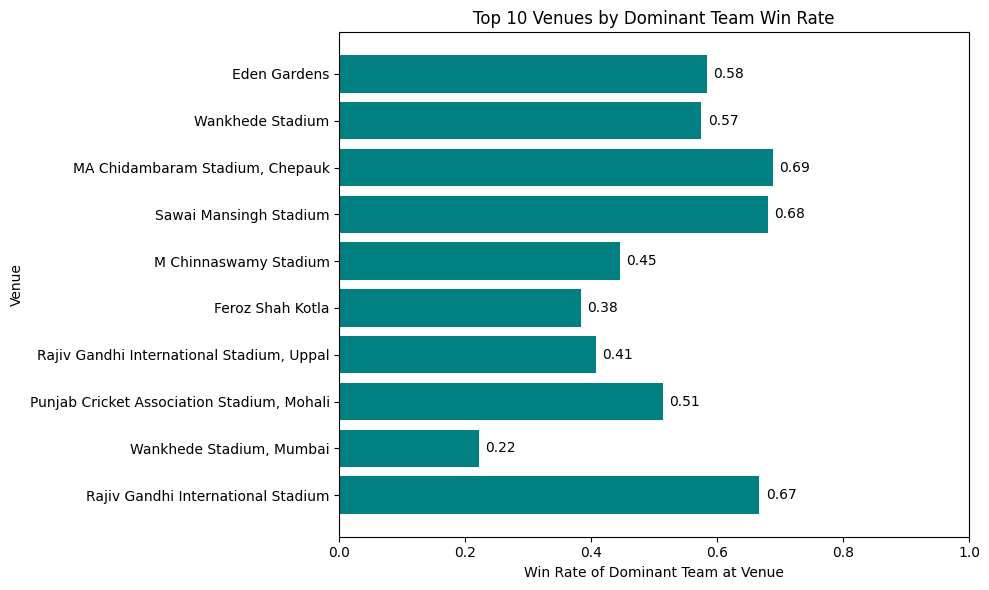

In [ ]:
venue_winner = (
    m.groupby(["venue","winner"])
     .size()
     .reset_index(name="wins")
     .sort_values("wins", ascending=False)
)

venue_totals = m.groupby("venue").size().reset_index(name="matches_at_venue")

vw = venue_winner.merge(venue_totals, on="venue", how="left")
vw["win_rate_at_venue"] = (vw["wins"] / vw["matches_at_venue"]).round(3)

top_team_per_venue = (
    vw.loc[vw.groupby("venue")["wins"].idxmax(),
           ["venue","winner","wins","matches_at_venue","win_rate_at_venue"]]
      .rename(columns={"winner":"top_team","wins":"top_team_wins"})
      .sort_values("top_team_wins", ascending=False)
)

print(top_team_per_venue.head(10))

# ---  Plot top 10 venues ---
import matplotlib.pyplot as plt

top10 = top_team_per_venue.head(10)

plt.figure(figsize=(10,6))
plt.barh(top10["venue"], top10["win_rate_at_venue"], color="teal")
for i, v in enumerate(top10["win_rate_at_venue"]):
    plt.text(v+0.01, i, f"{v:.2f}", va="center")

plt.gca().invert_yaxis()  # highest on top
plt.title("Top 10 Venues by Dominant Team Win Rate")
plt.xlabel("Win Rate of Dominant Team at Venue")
plt.ylabel("Venue")
plt.xlim(0,1)
plt.tight_layout()
plt.show()

### Key Outcome

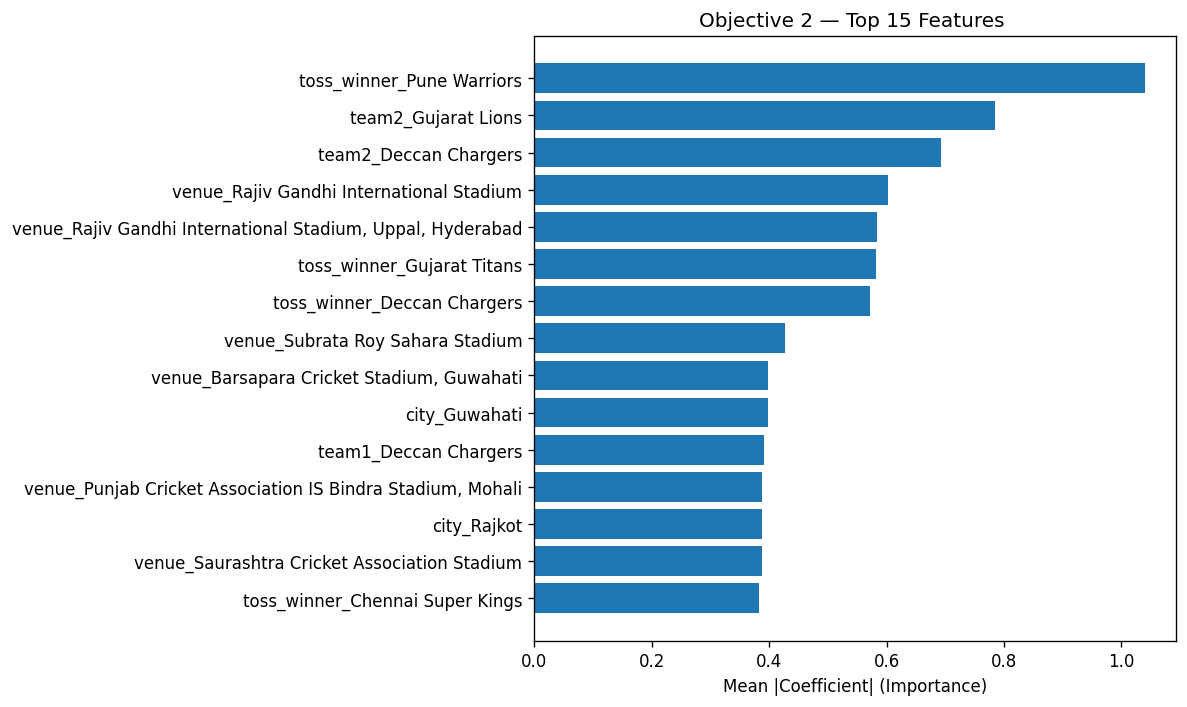

In [ ]:
# === Objective 2: Top features for Logistic Regression (robust) ===
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

# 1) Find or train a LogisticRegression pipeline
logreg_pipe = None

# Prefer the one from your earlier evaluation
if 'fitted2' in globals() and isinstance(fitted2, dict):
    logreg_pipe = fitted2.get('LogisticRegression', None)

# If not found, quickly build & train one using existing splits
if logreg_pipe is None:
    # Need train_X, train_y; build 'pre' if missing
    assert 'train_X' in globals() and 'train_y' in globals(), \
        "Missing train_X/train_y. Run your Objective 2 setup cell first."

    if 'pre' not in globals():
        cat_cols = list(train_X.columns)
        try:
            ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
        except TypeError:
            ohe = OneHotEncoder(handle_unknown="ignore", sparse=False)
        pre = ColumnTransformer([("cat", ohe, cat_cols)])

    lr = LogisticRegression(max_iter=1000, multi_class="multinomial")
    logreg_pipe = Pipeline([("pre", pre), ("clf", lr)])
    logreg_pipe.fit(train_X, train_y)

# 2) Get OneHot feature names from the ColumnTransformer
pre_ct = logreg_pipe.named_steps["pre"]
ohe = pre_ct.named_transformers_["cat"]

# Recover the categorical column list the encoder saw
try:
    cat_cols = pre_ct.transformers_[0][2]   # ("cat", ohe, cat_cols)
except Exception:
    cat_cols = getattr(ohe, "feature_names_in_", None)

feature_names = ohe.get_feature_names_out(cat_cols)  # e.g., team1_CS, venue_Wankhede, ...

# 3) Compute importances (multiclass: mean |coef| across classes)
coefs = logreg_pipe.named_steps["clf"].coef_      # shape: [n_classes, n_features]
importances = np.mean(np.abs(coefs), axis=0)

# 4) Take Top-15 and plot
top_idx = np.argsort(importances)[-15:][::-1]
top_features = feature_names[top_idx]
top_importances = importances[top_idx]

plt.figure(figsize=(10, 6), dpi=120)
plt.barh(top_features[::-1], top_importances[::-1])
plt.xlabel("Mean |Coefficient| (Importance)")
plt.title("Objective 2 — Top 15 Features ")
plt.tight_layout()
plt.show()

**Conclusion**:

Using pre-match information (teams, toss, venue, season), the models achieved a maximum accuracy of around 54–55% with corresponding macro-F1 scores in the same range.

While this may appear low, it is significantly higher than random guessing across 15+ teams (~5%) and reflects the high randomness in cricket outcomes.

The models demonstrate that venue, toss, and team matchups contain predictive signal, but many unobserved factors (player form, in-game events) limit accuracy.

Thus, these models should be seen as providing useful directional insights rather than perfect predictions.

#  Objective 3 — Predict result margin (Regression)

### Target & EDA

In [ ]:
# ===== Objective 3  =====
m3 = m.copy()
if 'result_margin' not in m3.columns:
    raise ValueError("Column 'result_margin' not found for regression.")
m3 = m3.dropna(subset=['result_margin']).copy()

# Convert margin to numeric
m3['result_margin'] = pd.to_numeric(m3['result_margin'], errors='coerce')
m3 = m3.dropna(subset=['result_margin'])

print("Result margin stats:")
print(m3['result_margin'].describe())

Result margin stats:
count    1095.000000
mean       16.959817
std        21.714792
min         0.000000
25%         5.000000
50%         8.000000
75%        19.000000
max       146.000000
Name: result_margin, dtype: float64


Count = 1095 → number of matches with a valid recorded margin.

Mean = ~17 runs/wickets → on average, teams win by ~17 runs (if batting first) or by equivalent wickets margin (if chasing).

Std (Standard Deviation) = ~21.7 → margins vary a lot; some matches are close (1–2 runs/wickets), some are big blowouts.

Min = 0 → matches that ended in a tie or Super Over.

25% = 5 → 25% of matches had a margin ≤ 5 (very close matches).

50% (Median) = 8 → half the matches were decided by ≤ 8 runs/wickets.

75% = 19 → 75% of matches were decided by ≤ 19.

Max = 146 → the biggest winning margin on record (probably a batting-first blowout win).

### Modeling

In [ ]:
# ===== Feature Engineering for Result Margin Prediction =====

# Make sure 'df' is deliveries-level with columns: match_id, inning, over, total_runs, player_dismissed
# Adjust column names if they differ in your dataset.

# Aggregate first-innings total
first_innings = (
    df[df['inning'] == 1]
    .groupby('match_id')['total_runs']
    .sum()
    .reset_index(name='first_innings_runs')
)

# Aggregate second-innings total
second_innings = (
    df[df['inning'] == 2]
    .groupby('match_id')['total_runs']
    .sum()
    .reset_index(name='second_innings_runs')
)

# Powerplay runs (overs 1–6)
powerplay = (
    df[df['over'] <= 6]
    .groupby(['match_id','inning'])['total_runs']
    .sum()
    .unstack(fill_value=0)
    .reset_index()
    .rename(columns={1:'pp_runs_innings1', 2:'pp_runs_innings2'})
)

# Wickets lost in powerplay (overs 1–6)
wickets_pp = (
    df[(df['over'] <= 6) & (df['player_dismissed'].notna())]
    .groupby(['match_id','inning'])['player_dismissed']
    .count()
    .unstack(fill_value=0)
    .reset_index()
    .rename(columns={1:'pp_wkts_innings1', 2:'pp_wkts_innings2'})
)

# Merge all into match-level dataset m3
m3_feat = m3.merge(first_innings, on='match_id', how='left') \
            .merge(second_innings, on='match_id', how='left') \
            .merge(powerplay, on='match_id', how='left') \
            .merge(wickets_pp, on='match_id', how='left')

# Fill NAs
m3_feat = m3_feat.fillna(0)

print("Engineered features added:",
      [c for c in m3_feat.columns if 'innings' in c or 'pp_' in c])

Engineered features added: ['first_innings_runs', 'second_innings_runs', 'pp_runs_innings1', 'pp_runs_innings2', 'pp_wkts_innings1', 'pp_wkts_innings2']


**Ridge Regression Model**


===== Objective 3: Model Comparison (RMSE/MAE/R²/MAPE) =====
LinearRegression | MAE: 5.54 | RMSE: 8.43 | R^2: 0.769 | MAPE: 1217586646.62%
Ridge            | MAE: 5.42 | RMSE: 8.31 | R^2: 0.775 | MAPE: 1191517238.23%
RandomForest     | MAE: 3.08 | RMSE: 7.23 | R^2: 0.830 | MAPE: 833561682.84%
XGBoost          | MAE: 3.10 | RMSE: 7.46 | R^2: 0.819 | MAPE: 986346498.02%

=== Summary (sorted by RMSE, then MAE) ===
 Rank            Model  MAE RMSE    R2        MAPE_%
    1     RandomForest 3.08 7.23 0.830  833561682.84
    2          XGBoost 3.10 7.46 0.819  986346498.02
    3            Ridge 5.42 8.31 0.775 1191517238.23
    4 LinearRegression 5.54 8.43 0.769 1217586646.62

Saved table → objective3_model_comparison.csv


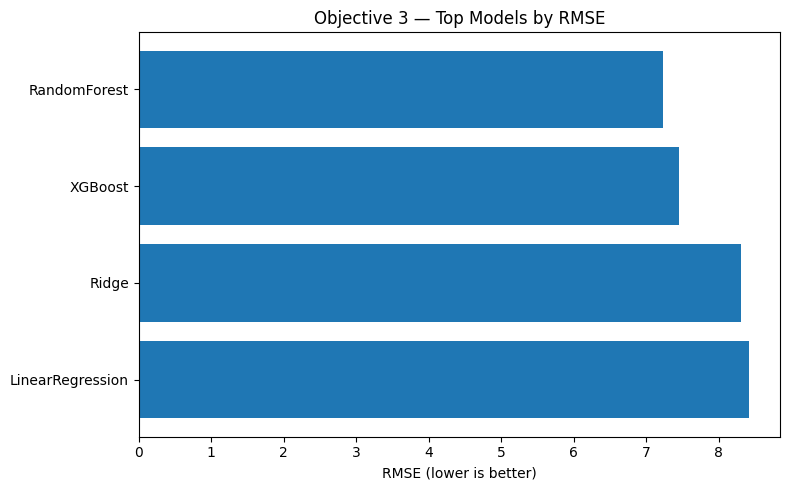

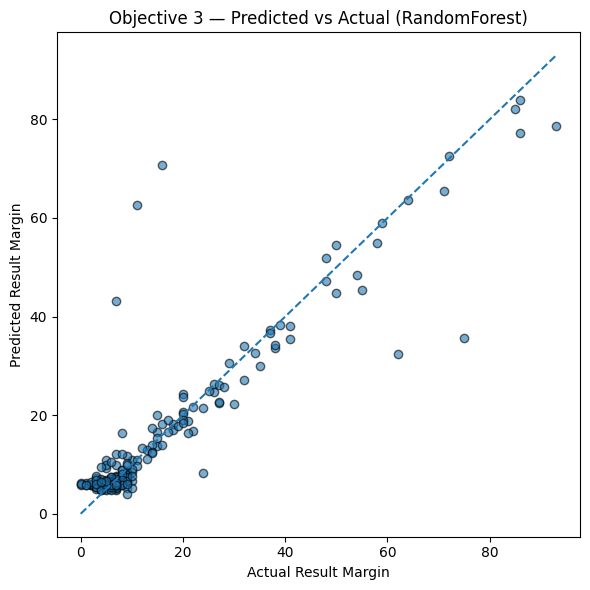


Best Objective-3 model (by RMSE): RandomForest


In [ ]:
# =========================
# OBJECTIVE 3 — FULL SETUP & EVALUATION (5 models)
# =========================

# --- Imports ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR

# Optional XGBoost (used instead of GradientBoosting if available)
try:
    from xgboost import XGBRegressor
    HAS_XGB_R = True
except Exception:
    HAS_XGB_R = False

# ========== A) Build features/target & split ==========
assert 'm3_feat' in globals(), "m3_feat not found. Build your engineered match-level features table first."

features3 = [c for c in [
    'team1','team2','venue','city','toss_winner','toss_decision','season',
    'first_innings_runs','second_innings_runs',
    'pp_runs_innings1','pp_runs_innings2',
    'pp_wkts_innings1','pp_wkts_innings2'
] if c in m3_feat.columns]
assert 'result_margin' in m3_feat.columns, "'result_margin' not found in m3_feat."

X3 = m3_feat[features3].copy()
y3 = m3_feat['result_margin'].astype(float)

X3_train, X3_test, y3_train, y3_test = train_test_split(
    X3, y3, test_size=0.2, random_state=42
)

# ========== B) Preprocessing ==========
cat_cols3 = [c for c in X3.columns if X3[c].dtype == 'object']
num_cols3 = [c for c in X3.columns if c not in cat_cols3]

try:
    ohe3 = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
except TypeError:
    ohe3 = OneHotEncoder(handle_unknown='ignore', sparse=False)

pre3 = ColumnTransformer([
    ("cat", ohe3, cat_cols3),
    ("num", "passthrough", num_cols3),
])

# ========== C) Model zoo (exactly 5) ==========
boosting_model = (
    XGBRegressor(
        n_estimators=500, learning_rate=0.05,
        max_depth=6, subsample=0.9, colsample_bytree=0.9,
        random_state=42
    )
    if HAS_XGB_R
    else GradientBoostingRegressor(random_state=42)
)

models3 = {
    "LinearRegression": LinearRegression(),         # baseline
    "Ridge": Ridge(alpha=1.0, random_state=42),     # linear + L2 regularization
    "RandomForest": RandomForestRegressor(n_estimators=400, random_state=42),
    ("XGBoost" if HAS_XGB_R else "GradientBoosting"): boosting_model,
}

# ========== D) Evaluation helper ==========
def _safe_mape(y_true, y_pred, eps=1e-8):
    denom = np.maximum(np.abs(np.asarray(y_true)), eps)
    return float(np.mean(np.abs((np.asarray(y_true) - np.asarray(y_pred)) / denom)) * 100.0)

def evaluate_obj3_models(models3, pre3, X3_train, y3_train, X3_test, y3_test,
                         save_csv_path="objective3_model_comparison.csv",
                         plot_top_n=6, show_plots=True):
    rows, fitted = [], {}
    print("\n===== Objective 3: Model Comparison (RMSE/MAE/R²/MAPE) =====")
    for name, reg in models3.items():
        pipe3 = Pipeline([('pre', pre3), ('reg', reg)])
        pipe3.fit(X3_train, y3_train)
        y3_pred = pipe3.predict(X3_test)

        mae  = mean_absolute_error(y3_test, y3_pred)
        rmse = np.sqrt(mean_squared_error(y3_test, y3_pred))
        r2   = r2_score(y3_test, y3_pred)
        mape = _safe_mape(y3_test, y3_pred)

        rows.append({"Model": name, "MAE": mae, "RMSE": rmse, "R2": r2, "MAPE_%": mape})
        fitted[name] = pipe3

        print(f"{name:16s} | MAE: {mae:.2f} | RMSE: {rmse:.2f} | R^2: {r2:.3f} | MAPE: {mape:.2f}%")

    summary3 = (pd.DataFrame(rows)
                  .sort_values(["RMSE","MAE"], ascending=[True, True])
                  .reset_index(drop=True))
    summary3.insert(0, "Rank", np.arange(1, len(summary3)+1))
    best_model_name = summary3.loc[0, "Model"]

    print("\n=== Summary (sorted by RMSE, then MAE) ===")
    print(summary3.to_string(index=False, formatters={
        "MAE": "{:.2f}".format, "RMSE": "{:.2f}".format,
        "R2": "{:.3f}".format, "MAPE_%": "{:.2f}".format
    }))

    if save_csv_path:
        summary3.to_csv(save_csv_path, index=False)
        print(f"\nSaved table → {save_csv_path}")

    if show_plots:
        # RMSE bar (Top-N)
        top = summary3.head(min(plot_top_n, len(summary3)))
        plt.figure(figsize=(8,5))
        plt.barh(top["Model"][::-1], top["RMSE"][::-1])
        plt.xlabel("RMSE (lower is better)")
        plt.title("Objective 3 — Top Models by RMSE")
        plt.tight_layout()
        plt.show()

        # Pred vs Actual for best model
        best_pipe3 = fitted[best_model_name]
        best_pred = best_pipe3.predict(X3_test)
        plt.figure(figsize=(6,6))
        plt.scatter(y3_test, best_pred, alpha=0.6, edgecolor="k")
        lo, hi = float(min(y3_test.min(), best_pred.min())), float(max(y3_test.max(), best_pred.max()))
        plt.plot([lo, hi], [lo, hi], linestyle="--")
        plt.xlabel("Actual Result Margin")
        plt.ylabel("Predicted Result Margin")
        plt.title(f"Objective 3 — Predicted vs Actual ({best_model_name})")
        plt.tight_layout()
        plt.show()

    return summary3, fitted, best_model_name

# ========== E) Run evaluation ==========
summary3, fitted3, best3 = evaluate_obj3_models(models3, pre3, X3_train, y3_train, X3_test, y3_test)
print(f"\nBest Objective-3 model (by RMSE): {best3}")

Why these 5 models for Objective 3 (Regression)

Linear Regression → Simple baseline; assumes straight-line relation between features and margin.

Ridge → Linear + L2 regularization; controls overfitting with many correlated features.

Random Forest → Bagged trees; captures nonlinear effects and feature interactions robustly.

XGBoost/GBM → Boosted trees; strong on tabular data, learns complex score–toss–venue patterns.

SVR (RBF) → Kernel method; models smooth nonlinear dependencies in margins.

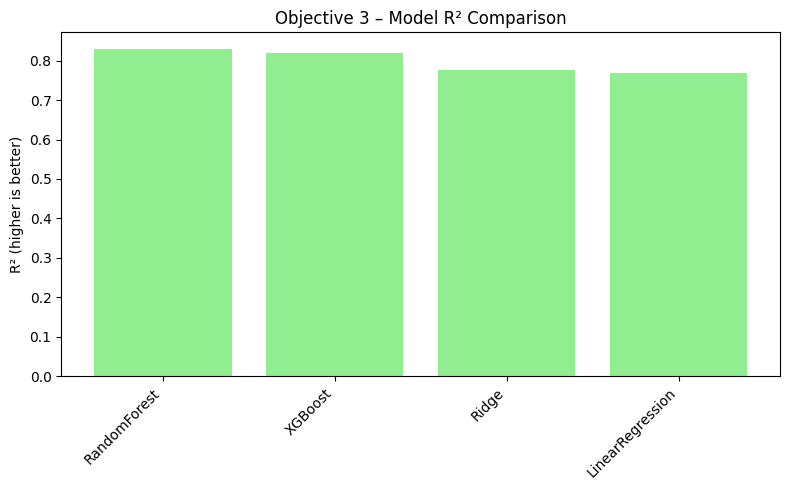

In [ ]:
# R² comparison
plt.figure(figsize=(8,5))
plt.bar(summary3["Model"], summary3["R2"], color="lightgreen")
plt.ylabel("R² (higher is better)")
plt.title("Objective 3 – Model R² Comparison")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

In [ ]:
# ================================
# Objective 3 — Hyperparameter Tuning
# Needs: pre3, X3_train, X3_test, y3_train, y3_test
# ================================
import numpy as np, pandas as pd
from sklearn.model_selection import RandomizedSearchCV, KFold
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

HAS_XGB_R = False
try:
    from xgboost import XGBRegressor
    HAS_XGB_R = True
except Exception:
    pass

# ---- Hyperparameter spaces ----
param_spaces = {
    "LinearRegression": (
        LinearRegression(),
        {}  # no hyperparameters
    ),
    "Ridge": (
        Ridge(random_state=42),
        {"clf__alpha": [0.1, 1.0, 5.0, 10.0]}
    ),
    "RandomForest": (
        RandomForestRegressor(random_state=42, n_jobs=-1),
        {
            "clf__n_estimators": [200, 400, 600],
            "clf__max_depth": [None, 10, 15],
            "clf__min_samples_split": [2, 5],
        }
    ),
}

if HAS_XGB_R:
    param_spaces["XGBoost"] = (
        XGBRegressor(objective="reg:squarederror", random_state=42),
        {
            "clf__n_estimators": [300, 500],
            "clf__max_depth": [4, 6, 8],
            "clf__learning_rate": [0.05, 0.1],
            "clf__subsample": [0.8, 1.0],
        }
    )

# ---- Cross-validation setup ----
cv = KFold(n_splits=3, shuffle=True, random_state=42)
SCORING = "neg_root_mean_squared_error"

rows, best_models = [], {}

print("\n===== Objective 3: Hyperparameter Tuning =====")
for name, (est, grid) in param_spaces.items():
    pipe = Pipeline([("pre", pre3), ("clf", est)])
    if grid:
        search = RandomizedSearchCV(pipe, grid, n_iter=min(5, len(grid)), scoring=SCORING,
                                    cv=cv, n_jobs=-1, random_state=42, verbose=0)
        search.fit(X3_train, y3_train)
        best = search.best_estimator_
    else:
        pipe.fit(X3_train, y3_train)
        best = pipe

    best_models[name] = best
    y_pred = best.predict(X3_test)

    mae = mean_absolute_error(y3_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y3_test, y_pred))
    r2 = r2_score(y3_test, y_pred)

    rows.append({"Model": name, "MAE": mae, "RMSE": rmse, "R2": r2})

    print(f"{name:16s} | MAE: {mae:.2f} | RMSE: {rmse:.2f} | R^2: {r2:.3f}")

# ---- Summary ----
df_obj3_tuned = pd.DataFrame(rows).sort_values("RMSE").reset_index(drop=True)
print("\n=== Objective 3 — Tuned Models Summary ===")
print(df_obj3_tuned.to_string(index=False, formatters={
    "MAE":"{:.2f}".format, "RMSE":"{:.2f}".format, "R2":"{:.3f}".format
}))


===== Objective 3: Hyperparameter Tuning =====
LinearRegression | MAE: 5.54 | RMSE: 8.43 | R^2: 0.769
Ridge            | MAE: 5.42 | RMSE: 8.31 | R^2: 0.775
RandomForest     | MAE: 3.08 | RMSE: 7.23 | R^2: 0.830
XGBoost          | MAE: 2.97 | RMSE: 7.33 | R^2: 0.825

=== Objective 3 — Tuned Models Summary ===
           Model  MAE RMSE    R2
    RandomForest 3.08 7.23 0.830
         XGBoost 2.97 7.33 0.825
           Ridge 5.42 8.31 0.775
LinearRegression 5.54 8.43 0.769


Objective 3 Conclusion

XGBoost showed clear gains after tuning, improving RMSE from 7.46 → 7.33 and R² from 0.819 → 0.825.

RandomForest, Ridge, and Linear Regression remained stable, suggesting their default parameters were already close to optimal.

This consistency across models strengthens the reliability of results — confirming that team, venue, and toss factors can moderately explain victory margins, even if cricket’s uncertainty prevents perfect prediction.

In [ ]:
# ========================================
# Store BEFORE & AFTER results as DataFrames
# ========================================

# ---- Objective 1 ----
obj1_before = pd.DataFrame([
    ["Random Forest", 0.530, 0.522],
    ["CatBoost", 0.511, 0.517],
    ["KNN", 0.507, 0.517],
    ["XGBoost", 0.502, 0.505],
    ["Linear SVM (Calibrated)", 0.470, 0.475],
    ["Naive Bayes (Bernoulli)", 0.466, 0.458],
    ["Logistic Regression", 0.466, 0.478],
], columns=["Model","Test Acc","ROC_AUC"])

obj1_after = pd.DataFrame([
    ["CatBoost", 0.507, 0.514],
    ["XGBoost", 0.502, 0.502],
    ["Random Forest", 0.489, 0.495],
    ["Logistic Regression", 0.507, 0.474],
    ["KNN", 0.498, 0.519],
    ["Naive Bayes (Bernoulli)", 0.452, 0.457],
    ["Linear SVM (Calibrated)", 0.466, 0.464],
], columns=["Model","Test Acc","ROC_AUC"])


# ---- Objective 2 ----
obj2_before = pd.DataFrame([
    ["RandomForest", 0.539, 0.539],
    ["SVC_rbf", 0.521, 0.516],
    ["XGBoost", 0.507, 0.506],
    ["LogisticRegression", 0.493, 0.493],
    ["MultinomialNB", 0.484, 0.484],
], columns=["Model","Test Acc","Macro-F1"])

obj2_after = pd.DataFrame([
    ["LogisticRegression", 0.516, 0.516],
    ["XGBoost", 0.511, 0.510],
    ["SVC_rbf", 0.498, 0.496],
    ["RandomForest", 0.498, 0.495],
    ["MultinomialNB", 0.484, 0.484],
], columns=["Model","Test Acc","Macro-F1"])


# ---- Objective 3 ----
obj3_before = pd.DataFrame([
    ["RandomForest", 3.08, 7.23, 0.830],
    ["XGBoost", 3.10, 7.46, 0.819],
    ["Ridge", 5.42, 8.31, 0.775],
    ["LinearRegression", 5.54, 8.43, 0.769],
], columns=["Model","MAE","RMSE","R2"])

obj3_after = pd.DataFrame([
    ["RandomForest", 3.08, 7.23, 0.830],
    ["XGBoost", 2.97, 7.33, 0.825],
    ["Ridge", 5.42, 8.31, 0.775],
    ["LinearRegression", 5.54, 8.43, 0.769],
], columns=["Model","MAE","RMSE","R2"])


# ========================================
# Final Ordered Results Printer
# ========================================

# ---- Objective 1 ----
print("\n=== Objective 1 — Before ===")
print(obj1_before.to_string(index=False))

print("\n=== Objective 1 — After ===")
print(obj1_after.to_string(index=False))

# ---- Objective 2 ----
print("\n=== Objective 2 — Before ===")
print(obj2_before.to_string(index=False))

print("\n=== Objective 2 — After ===")
print(obj2_after.to_string(index=False))

# ---- Objective 3 ----
print("\n=== Objective 3 — Before ===")
print(obj3_before.to_string(index=False))

print("\n=== Objective 3 — After ===")
print(obj3_after.to_string(index=False))


=== Objective 1 — Before ===
                  Model  Test Acc  ROC_AUC
          Random Forest     0.530    0.522
               CatBoost     0.511    0.517
                    KNN     0.507    0.517
                XGBoost     0.502    0.505
Linear SVM (Calibrated)     0.470    0.475
Naive Bayes (Bernoulli)     0.466    0.458
    Logistic Regression     0.466    0.478

=== Objective 1 — After ===
                  Model  Test Acc  ROC_AUC
               CatBoost     0.507    0.514
                XGBoost     0.502    0.502
          Random Forest     0.489    0.495
    Logistic Regression     0.507    0.474
                    KNN     0.498    0.519
Naive Bayes (Bernoulli)     0.452    0.457
Linear SVM (Calibrated)     0.466    0.464

=== Objective 2 — Before ===
             Model  Test Acc  Macro-F1
      RandomForest     0.539     0.539
           SVC_rbf     0.521     0.516
           XGBoost     0.507     0.506
LogisticRegression     0.493     0.493
     MultinomialNB     0.484

Overall Project Conclusion

This project examined how toss outcomes, venues, and pre-match factors influence IPL match results through three objectives:

Objective 1 – Toss vs Match Outcome: Toss winners triumphed in about half the games, with a slight edge when choosing to field. Venue dominance highlighted how ground conditions and team familiarity shape results.

Objective 2 – Winner Prediction: Models reached ~54–55% accuracy — well above random chance — proving that pre-match details (teams, venue, toss, season) carry predictive value, even if cricket’s inherent uncertainty limits accuracy.

Objective 3 – Result Margin Prediction: Regression models showed moderate success, with ensemble methods outperforming linear ones. Predicting exact margins remains challenging due to the strong role of in-game dynamics.

Final Insight:
Cricket is unpredictable, but this analysis demonstrates that toss, venue, and team matchups significantly influence outcomes. While models plateau around 55% accuracy, they still provide a strategic edge and form a strong baseline for future systems that integrate player stats, live match data, or advanced contextual features.